# Setup

## Imports

In [1]:
# Setup
import os
import joblib
import pickle
import json
from utils.custom_transformers import ColumnSelector, CategoricalTransformer, SaveTransformer, NumericalTransformer

# Data Analysis
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

#Scikit learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc, plot_confusion_matrix

## Configs

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
seed = 42

## Functions

In [3]:
def load_data(file_name, folder = "data"):
    df = pd.read_csv(os.path.join(folder, file_name))
    return df

def target_transformation(text):
    text = text.replace(" ", "").lower()
    if text == "yes" :
        return 1
    elif text == "no":
        return 0

# Data Analysis

## Data Load

In [4]:
df_original = load_data("train_data.csv","data")

In [5]:
df_original.columns

Index(['admission_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'admission_type_code', 'discharge_disposition_code',
       'admission_source_code', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'has_prosthesis', 'complete_vaccination_status',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'blood_type',
       'hemoglobin_level', 'blood_transfusion', 'max_glu_serum', 'A1Cresult',
       'diuretics', 'insulin', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

## Exploratory Data Analysis

### Overall Analysis

In [ ]:
df_original.dtypes

In [6]:
df_original['change'].value_counts()

No    43772
Ch    37640
Name: change, dtype: int64

In [ ]:
df_original.isna().sum()

# Pipelines

## Custom Transformers

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [ ]:
class Save(BaseEstimator, TransformerMixin):
    
    def __init__(self, step):
        self.step = step
        pass
    
    def fit(self, X=None, y=None, **fit_params):
        return self
    
    def transform(self, data):
        X = data.copy()
        name = "pipeline_"+self.step+"_spy.csv"
        pd.DataFrame(X).head(50).to_csv(name)
        return X

In [ ]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def pre_process_text(self, obj):
        return str(obj).replace(" ","").lower()
    
    def bool_to_binary(self, obj):
        if obj == True:
            return 1
        elif obj == False:
            return 0
    
    def text_to_binary(self, obj):
        if obj == "yes" or obj == "ch"  :
            return 1
        elif obj == "no":
            return 0
    
    def handle_missing_values(self, obj):
        if pd.isna(obj) or str(obj) == "?" or str(obj) == "unknown/invalid" or str(obj) == "nan" :
            return np.nan
        else :
            return obj
        
    def transform(self, X, y=None):
        _X = X.copy()
        for _col in _X:     
            if _col in ['has_prosthesis','blood_transfusion']:
                _X[_col] = _X[_col].apply(self.bool_to_binary)
            elif _col in ['diuretics','insulin','change','diabetesMed','readmitted']:
                _X[_col] = _X[_col].apply(self.pre_process_text)
                _X[_col] = _X[_col].apply(self.text_to_binary)
            elif _col in ['admission_source_code','discharge_disposition_code','admission_type_code','race','gender','age','weight','payer_code','medical_specialty','complete_vaccination_status','blood_type','max_glu_serum','A1Cresult','diag_1','diag_2','diag_3']:
                _X[_col] = _X[_col].apply(self.pre_process_text)
                _X[_col] = _X[_col].apply(self.handle_missing_values)
            
        return _X

In [ ]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self
    
    def missing_to_zero(self, obj):
        if pd.isna(obj):
            return 0
        else :
            return obj
    
    def return_float(self, obj):
        return float(obj)
    
    def return_int(self, obj):
        return int(obj)
        
    def transform(self, X, y=None):
        _X = X.copy()
        for _col in _X:
            if _col in ['num_lab_procedures','num_procedures','num_medications']:
                _X[_col] = _X[_col].apply(self.missing_to_zero)
                _X[_col] = _X[_col].apply(self.return_int)
            elif _col in ['time_in_hospital','number_outpatient','number_emergency','number_inpatient','number_diagnoses']:
                _X[_col] = _X[_col].apply(self.return_int)
            elif _col in ['hemoglobin_level']:
                _X[_col] = _X[_col].apply(self.return_float)
        return _X

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_original.drop(columns=['readmitted']), 
                                                    df_original['readmitted'],
                                                    shuffle = False,
                                                    test_size=.4, 
                                                    random_state=seed)

In [7]:
y_train = y_train.apply(target_transformation)
y_test = y_test.apply(target_transformation)

In [8]:
categorical = ['change','diabetesMed','has_prosthesis','blood_transfusion','diuretics','insulin','admission_source_code','discharge_disposition_code','admission_type_code','payer_code','complete_vaccination_status','blood_type','max_glu_serum','A1Cresult']#,'age','race','gender','weight','diag_1','diag_2','diag_3','medical_specialty']
numerical = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses','hemoglobin_level']

cat_pipe = Pipeline([
    ('selector', ColumnSelector(categorical))
    ,('transformer',CategoricalTransformer())
    #,("save_to_csv_cat1", Save(step="cat1"))
    ,('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
    ,('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    #,("save_to_csv_cat2", Save(step="cat2"))
])

num_pipe = Pipeline([
    ('selector', ColumnSelector(numerical))
    ,('transformer',NumericalTransformer())
    #,("save_to_csv_num1", Save(step="num1"))
    ,('imputer', SimpleImputer(strategy='median'))
    ,('scaler', MinMaxScaler())
    #,("save_to_csv_num2", Save(step="num2"))
])

pre_processor = FeatureUnion([
    ('cat', cat_pipe)
    ,('num', num_pipe)
])

pipeline = Pipeline([
    ('preprocessor', pre_processor)
    ,('model', GradientBoostingClassifier())
])

pipeline.fit(X_train, y_train)

# Predict training data
y_train_pred = pipeline.predict(X_train)
print(f"Predictions on training data: {y_train_pred}")

# Predict test data
y_test_pred = pipeline.predict(X_test)
print(f"Predictions on test data: {y_test_pred}")


Predictions on training data: [0 0 0 ... 0 0 0]
Predictions on test data: [0 0 0 ... 0 0 0]


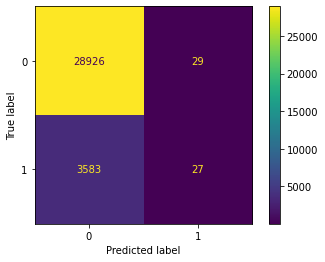

In [10]:
plot_confusion_matrix(pipeline, X_test, y_test)  
plt.show()

ROC-AUC:


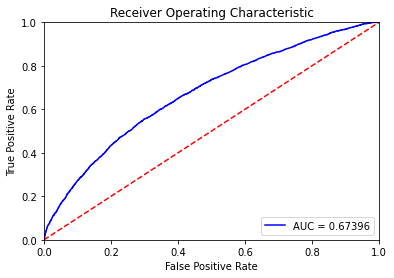

In [11]:
y_scores = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
print("ROC-AUC:")
plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [12]:
for a in np.linspace(0,1,20):
    y_scores_treshold = [1 if x > a else 0 for x in y_scores]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores_treshold, pos_label=1)
    print("With treshold = {} AUC of {}".format(a,auc(fpr, tpr)))

With treshold = 0.0 AUC of 0.5
With treshold = 0.05263157894736842 AUC of 0.5173117278650462
With treshold = 0.10526315789473684 AUC of 0.6251545166800523
With treshold = 0.15789473684210525 AUC of 0.5979917495435414
With treshold = 0.21052631578947367 AUC of 0.558757595485592
With treshold = 0.2631578947368421 AUC of 0.5375816710522728
With treshold = 0.3157894736842105 AUC of 0.5279421788801134
With treshold = 0.3684210526315789 AUC of 0.513527342791446
With treshold = 0.42105263157894735 AUC of 0.5071356546671187
With treshold = 0.47368421052631576 AUC of 0.5037583153914925
With treshold = 0.5263157894736842 AUC of 0.5023556469083988
With treshold = 0.5789473684210527 AUC of 0.501731840074698
With treshold = 0.631578947368421 AUC of 0.5005889117270997
With treshold = 0.6842105263157894 AUC of 0.5001906674364797
With treshold = 0.7368421052631579 AUC of 0.5002252037859876
With treshold = 0.7894736842105263 AUC of 0.5001212359803706
With treshold = 0.8421052631578947 AUC of 0.50013850

# Model


In [13]:
TMP_DIR = '/tmp'

In [14]:
with open(os.path.join(TMP_DIR, "columns.json"), 'w') as fh:
    json.dump(df_original.columns.tolist(), fh)

with open(os.path.join(TMP_DIR, "dtypes.pickle"), 'wb') as fh:
    pickle.dump(df_original.dtypes, fh)
    
joblib.dump(pipeline, os.path.join(TMP_DIR, 'pipeline.pickle')) 

['/tmp/pipeline.pickle']